# Stability with terminal state constraint
We have the following LTI dynamics

$$ x_{k+1} = A\, x_k + B \,u_k  = \left[\begin{smallmatrix} 1 & 0.05 \\ 0.2 & 1.2 \end{smallmatrix}\right] x_k + \left[\begin{smallmatrix}  0.3 & 0\\ 0 & 1\end{smallmatrix}\right] u_k.$$

Solve the following optimal control problem (OPC)

\begin{array}{ll} \mbox{minimize} & \sum_{k=0}^{K-1} x_k^T Q x_k +  \, u_k^T R u_k\\
\mbox{subject to} & x_{k+1} = Ax_k + Bu_k\\%, \quad k=0, \ldots, K-1\\
& \| u_k\|_{2}\leq 6, \quad x_K= 0,
%, \quad \quad k=0, \ldots, K
\end{array}

with $Q = \left[\begin{smallmatrix} 0.2 & 0 \\ 0 & 0.15 \end{smallmatrix}\right]$ and $R = \left[\begin{smallmatrix} 2 & 0 \\ 0 & 1.1 \end{smallmatrix}\right]$.

In [1]:
import numpy as np
import cvxpy as cp

# Generate data for control problem.

n_x, n_u = 2,2

A = np.array([[1,0.05], [0.2,1.2]])
B = np.array([[0.3, 0], [0, 1]])

Q = np.array([[0.2,0], [0,0.15]])
R = np.array([[2,0], [0,1.1]])


# Initial condition x_t

x_t = np.array([5,-8])

# Prediction horizon length

K = 10

**Step 1:**

Solve for the MPC problem at $x(t)= \left[\begin{smallmatrix} 5  \\ -8 \end{smallmatrix}\right]$ and store the optimal input sequence $\{u_k^*\}_{k=0}^{K-1}$ and $\{x_k^*\}_{k=0}^{K}$ and compute the optimal cost $J^*(x(t))$.

In [2]:
x = cp.Variable((n_x, K + 1))
u = cp.Variable((n_u, K))

cost = 0
constr = []
for k in range(K):
  cost +=  cp.quad_form(x[:, k],Q) + cp.quad_form(u[:, k],R)
  constr += [x[:, k + 1] == A @ x[:, k] + B @ u[:, k], cp.norm(u[:, k], 2) <= 6]

# sums problem objectives and concatenates constraints.
constr += [x[:, K] == 0, x[:, 0] == x_t]
problem = cp.Problem(cp.Minimize(cost), constr)
problem.solve()

print("The optimal state trajectory is: ", str(x.value))
print("The optimal input trajectory is: ", str(u.value))
print("The optimal cost is: " + str(problem.value))

J_star_t = problem.value

The optimal state trajectory is:  [[ 5.00000000e+00  4.19912908e+00  3.51565331e+00  2.92035532e+00
   2.39209483e+00  1.91537049e+00  1.47871793e+00  1.07369947e+00
   6.94334383e-01  3.36888637e-01 -3.99392552e-15]
 [-8.00000000e+00 -6.06221036e+00 -4.68871668e+00 -3.69729043e+00
  -2.96207115e+00 -2.39387666e+00 -1.92631760e+00 -1.50550303e+00
  -1.08169691e+00 -6.01596210e-01  6.13851397e-16]]
The optimal input trajectory is:  [[-1.33623641 -1.26788417 -1.20287386 -1.1446532  -1.09540262 -1.0565291
  -1.0290086  -1.01363312 -1.011203   -1.02269609]
 [ 2.53778964  1.74610993  1.22603892  0.8906063   0.68218975  0.56326029
   0.51033451  0.51016683  0.55757321  0.65453772]]
The optimal cost is: 79.5854067580401


**Step 2:**

Generate the shifted sequence which is feasible but suboptimal sequence as
$\tilde{U}= \{u_1^*,\dots,u_{K-1}^*, 0\}$ and $\tilde{X}=\{x_1^*,\dots,x_{K}^*, 0\}$. Compute the suboptimal cost for this shifted sequence $\tilde{J}$.

In [3]:
x_tilde = np.hstack([x.value[:,1:],np.zeros([2,1])])
u_tilde = np.hstack([u.value[:,1:],np.zeros([2,1])])

#%% Compute J_tilde, suboptimal cost for shifted sequence

J_tilde = 0

for k in range(K):

    J_tilde += x_tilde[:,k].T @ Q @ x_tilde[:,k] + u_tilde[:,k].T @ R @ u_tilde[:,k]

print("The suboptimal cost for the shifted sequence is: " + str(J_tilde))

# Check the value of g(x_0,u_0) = x.value[:,0].T@ Q @ x.value[:,0]+ u.value[:,0].T @ R @ u.value[:,0].T

g_x0_u0 = x.value[:,0].T@ Q @ x.value[:,0]+ u.value[:,0].T @ R @ u.value[:,0].T

print("The stage cost of the previous step is: " + str(g_x0_u0))

The suboptimal cost for the shifted sequence is: 54.32993733855213
The stage cost of the previous step is: 25.25546941948797


**Step 3:**

Apply the optimal input $u_0^*$ to compute the next system state: $x(t+1) = A\,x(t) + B\,u_0^*$. In reality the new state $x(t+1)$ would be a measurement from the plant/system and would not be computed.

In [4]:

x_next = A @ x_t + B @ u.value[:,0]


#Sanity check, our state at the next time step t+1 should equal to the optimal state sequence at step 1
print(x_next)

x.value[:,1]

[ 4.19912908 -6.06221036]


array([ 4.19912908, -6.06221036])

**Step 4:**

Solve the optimal input and state sequence at $x(t+1)$ and get the optimal cost $J^*(x(t))$

In [5]:
x = cp.Variable((n_x, K + 1))
u = cp.Variable((n_u, K))

cost = 0
constr = []
for k in range(K):
  cost +=  cp.quad_form(x[:, k],Q) + cp.quad_form(u[:, k],R)
  constr += [x[:, k + 1] == A @ x[:, k] + B @ u[:, k], cp.norm(u[:, k], 2) <= 6]

# sums problem objectives and concatenates constraints.
constr += [x[:, K] == 0, x[:, 0] == x_next]
problem = cp.Problem(cp.Minimize(cost), constr)
problem.solve()

print("The optimal state trajectory is: ", str(x.value))
print("The optimal input trajectory is: ", str(u.value))
print("The optimal cost is: " + str(problem.value))

J_star_next = problem.value

The optimal state trajectory is:  [[ 4.19912908e+00  3.54461337e+00  2.97976879e+00  2.48317697e+00
   2.03914751e+00  1.63601937e+00  1.26505035e+00  9.19726865e-01
   5.95392908e-01  2.89147130e-01 -1.33072914e-15]
 [-6.06221036e+00 -4.66437000e+00 -3.66383635e+00 -2.93278603e+00
  -2.38243070e+00 -1.94919102e+00 -1.58485057e+00 -1.24912108e+00
  -9.03434946e-01 -5.04976316e-01  1.83895744e-16]]
The optimal input trajectory is:  [[-1.17135064 -1.10542024 -1.04466669 -0.99130052 -0.94668868 -0.91169826
  -0.88693651 -0.87292634 -0.87024677 -0.87966105]
 [ 1.77045661  1.22448499  0.86786383  0.64027714  0.50189632  0.42697478
   0.39968953  0.41156498  0.46006704  0.54814215]]
The optimal cost is: 51.994961095952476


**Note that:**

At $x(t+1)$ the optimal input for prediction step $k=K-1$ is not zero, which shows that the previous sequence $\tilde{U}$ was suboptimal.

In [6]:
print(u_tilde[:,-1])
print(u.value[:,-1])

[0. 0.]
[-0.87966105  0.54814215]


**Step 5:**

Compare the costs $J^*(x(t)), \tilde{J}, J^*(x(t+1))$.

Can you verify that the optimal cost of the MPC problem fulfills the following inequality: $J^*(x(t+1))\leq \tilde{J} < J^*(x(t)),\quad \forall x(t)\not= 0 $?.

In [7]:
# Let's check with the code

print(J_star_t)
print(J_tilde)
print(J_star_next)

#Yes, the inequality is verfied

79.5854067580401
54.32993733855213
51.994961095952476


### Exercise 1
Solve the OPC above in a receding-horizon fashion (MPC) and compare the outputs to first the open-loop trajectories inititalized at $x(t)$ for a control horizon of $T=100$.

Start with the initial condition $x(t) = \left[\begin{smallmatrix} 5  \\ -8 \end{smallmatrix}\right]$ and compare the outputs for different prediction horizon lengths of $K = 3, 5, 7, 10 $.

For implementing the cost the follwoing cvxpy function might be helpful:



```
cp.quad_form(...,Q)
```



For plotting the open-loop and closed-loop MPC trajectories you can use the following lines of code:

```
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].plot(x_open[0,:], x_open[1,:], marker = 'x')
axs[1].plot(x_traj[0,:], x_traj[1,:], marker = 'x')
```



Text(0.5, 1.0, 'Closed-loop')

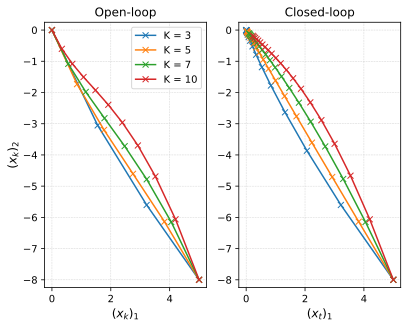

In [8]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
#%% Closed-loop

T = 20 # Control horizon
K_all = 3,5,7,10

fig, axs = plt.subplots(nrows=1, ncols=2)

cost_closed = {}
cost_open = {}

for K in K_all:

    x_0 = np.array([5,-8])

    x_traj = np.zeros([n_x, T+1])
    u_traj =  np.zeros([n_u, T])

    x_traj[:, 0] = x_0

    cost_closed[K] = 0

    for t in range(T):

        x = cp.Variable((n_x, K + 1))
        u = cp.Variable((n_u, K))

        cost = 0
        constr = []
        for k in range(K):
            cost +=  cp.quad_form(x[:, k],Q) + cp.quad_form(u[:, k],R)
            constr += [x[:, k + 1] == A @ x[:, k] + B @ u[:, k], cp.norm(u[:, k], 2) <= 6]
        # sums problem objectives and concatenates constraints.
        constr += [x[:, K] == 0, x[:, 0] == x_0]
        problem = cp.Problem(cp.Minimize(cost), constr)
        problem.solve()

        if t == 0:
            cost_open[K] = problem.value
            x_open = x.value.copy()
            u_open = u.value.copy()

        cost_closed[K] +=  x_0.T @ Q @ x_0 + u[:,0].value.T @ R @ u[:,0].value

        x_0 = A @ x_0 + B @ u[:,0].value

        u_traj[:, t] = u[:,0].value
        x_traj[:, t+1] = x_0



    axs[0].plot(x_open[0,:], x_open[1,:], marker = 'x')
    axs[1].plot(x_traj[0,:], x_traj[1,:], marker = 'x')


axs[0].set_ylim([-8.25,0.25])
axs[0].set_xlim([-0.25,5.25])
axs[1].set_ylim([-8.25,0.25])
axs[1].set_xlim([-0.25,5.25])

axs[0].grid(which='both', axis='both',color='lightgrey', linestyle='--', linewidth=0.5)
axs[0].set_ylabel(r"$(x_k)_2$", fontsize=12)
axs[0].set_xlabel(r"$(x_k)_1$", fontsize=12)
axs[0].set_title('Open-loop', fontsize=12)
axs[0].legend(['K = ' + str(K_all[0]), 'K = ' + str(K_all[1]), 'K = ' + str(K_all[2]),'K = ' + str(K_all[3])]
              ,fontsize=10)

axs[1].grid(which='both', axis='both',color='lightgrey', linestyle='--', linewidth=0.5)
axs[1].set_xlabel(r"$(x_t)_1$", fontsize=12)
axs[1].set_title('Closed-loop', fontsize=12)


**Question 2:**

Do the open and closed-loop trajectories match? If not, explain in your own words why this is not the case.

**Answer 2:**

They do not match as the closed-loop trajectory at every time step gets one more step to reach the terminal state $x_K =0$. Thus, it can reoptimize and find a state $x^*$ and input sequence $u^*$ which fulfils the terminal state constraint but at a smaller cost.

**Question 3:**

Why does it take so long for the closed-loop trajectory for K=10 to converge to zero? Would that be a "problem" in a real-life application?

**Answer 3:**

 The system is asymptotically stable due to the terminal state constraint as stated in the Theorem Slide 24 of the MPC lecture.  However, the stability result only hold asymptotically as $T \to \infty$. If for a specific application it was inmportant that the state reaches faster this would have to be taken into consideration when desiging the state cost matrix $Q$ (weighting the state more).